In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

/Users/yuliagoryachev/miniconda3/envs/mlx_course/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("ylecun/mnist")
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [3]:
#create a dataset where I have an encoder and I train it to predict the digit basic classifier but with a
#attention architecture, split the image into 4 parts (flatten each part and encode) and then use the attention to predict the digit

import torch
from torch import nn
from torch.utils.data import DataLoader
torch.manual_seed(123)


ds['train'][0]['image']

In [4]:
#matrix multiplication
import numpy as np

emb = np.array([[1,1,1], [2,2,2]])
emb = emb.reshape(1,2,3)
emb.shape

(1, 2, 3)

In [5]:
#positional encodings
def positional_encoding(position: int, d_model: int):
    """
    position (int): Length of the sequence
    d_model (int): Dimensionality of the model's output
    """
 
    # Create a matrix of shape [position, d_model] where each element is the position index
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    
    # Apply sine to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # Apply cosine to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return pos_encoding.astype(np.float32)

# Example use
position = 50  # Length of the sequence
d_model = 512  # Dimensionality of the model's output
pos_encoding = positional_encoding(position, d_model)

print(pos_encoding.shape)  # Output the shape to verify the dimensions

(1, 50, 512)


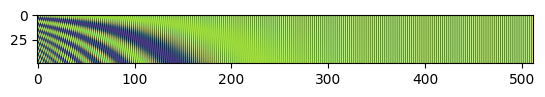

In [6]:
signal = np.ones((1, 50, 512))
res = signal+pos_encoding

plt.imshow(res[0])
plt.show()

In [7]:
#prepare the data
def prepare_data(data):
    #create 4 sequences out of each image
    data['image'] = torch.tensor(np.array(data['image']), dtype=torch.float32).view(4, 14, 14)
    #reshape the image to 4 sequences
    data['image'] = data['image'].reshape(4, 14*14)
    #normalize the image
    data['image'] = data['image'] / 255
    return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(data['label'], dtype=torch.long)

tens, label = prepare_data(ds['train'][0])

/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_22416/596500830.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(data['label'], dtype=torch.long)


In [8]:
#prepare dataloader that splits the image into 4 parts
class ImageDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return prepare_data(self.data[idx])
    
    def collate_fn(batch):
        images, labels = zip(*batch)
        images = torch.stack(images)
        labels = torch.stack(labels)
        return images, labels

train_dataset = ImageDataset(ds['train'])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=ImageDataset.collate_fn)

test_dataset = ImageDataset(ds['test'])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=ImageDataset.collate_fn)


In [9]:
print('n batches: ', len(train_loader))
print('n batches: ', len(test_loader))

n batches:  1875
n batches:  313


--------

-------

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        Args:
            d_model (int): Dimensionality of the model (embedding size).
            max_len (int): Maximum length of input sequences.
        """
        super(PositionalEncoding, self).__init__()
        # Create a long enough 'pe' matrix with shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # Apply sin to even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Apply cos to odd indices
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x (Tensor): Input of shape (batch_size, seq_len, d_model)
        Returns:
            Tensor: x plus positional encodings.
        """
        # print('before encoding:', x.shape)
        # print('pe shape:', self.pe[:, :x.size(1)].shape)
        x = x + self.pe[:, :x.size(1)]
        return x

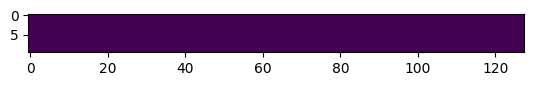

torch.Size([4, 10, 128])


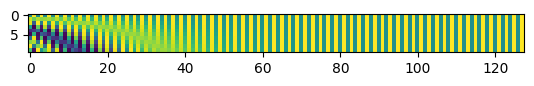

In [11]:
p = PositionalEncoding(128)
x = torch.ones(4, 10, 128)
plt.imshow(x[0].detach().numpy())
plt.show()
x = p(x)
print(x.shape)  # Expected: (4, 10, 128)
plt.imshow(x[0].detach().numpy())
plt.show()

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head
        # Linear projections for queries, keys, and values.
        self.linear_q = nn.Linear(d_model, d_model)
        self.linear_k = nn.Linear(d_model, d_model)
        self.linear_v = nn.Linear(d_model, d_model)
        
        # Final linear layer after concatenating heads.
        self.linear_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # Linear projections and reshape into (batch_size, num_heads, seq_len, d_k)
        print('attention shapes:')
        print('original shape: ', self.linear_q(query).shape)
        print(self.linear_q(query).view(batch_size, -1, self.num_heads, self.d_k).shape)
        Q = self.linear_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        print('shape after multihead preparation: ', Q.shape)
        K = self.linear_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        print('K: ', K.shape)
        V = self.linear_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        print('V :', V.shape)
        
        # Compute scaled dot-product attention.
        # scores: (batch_size, num_heads, seq_len, seq_len)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        print('scores shape: ', scores.shape)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        
        # Compute weighted sum of values.
        # context: (batch_size, num_heads, seq_len, d_k)
        context = torch.matmul(attn, V)
        print('context shape: ', context.shape)
        # Concatenate heads and put through final linear layer.
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        output = self.linear_out(context)
        return output, attn

In [13]:
sample = torch.rand(4, 10, 128)
sample_new = sample.view(4, -1, 2, 64)
print(sample_new.shape)
sample_new = sample_new.transpose(1, 2)
print(sample_new.shape)

torch.Size([4, 10, 2, 64])
torch.Size([4, 2, 10, 64])


In [14]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        
        # Position-wise feed-forward network.
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        # Multi-head self-attention sublayer with residual connection.
        attn_output, attn_weights = self.self_attn(x, x, x, mask)
        #here is the residual connection
        x = self.layernorm1(x + self.dropout1(attn_output))
        
        # Feed-forward sublayer with residual connection.
        ffn_output = self.ffn(x)
        x = self.layernorm2(x + self.dropout2(ffn_output))
        return x, attn_weights


In [15]:
class TransformerEncoder(nn.Module):
    def __init__(self, image_size, d_model, num_layers, num_heads, d_ff, max_seq_len, n_categories, dropout=0.1):
        """
        Args:
            vocab_size (int): Vocabulary size.
            d_model (int): Model dimension.
            num_layers (int): Number of encoder layers.
            num_heads (int): Number of attention heads.
            d_ff (int): Feed-forward dimension.
            max_seq_len (int): Maximum sequence length.
            dropout (float): Dropout probability.
        """
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Linear(image_size*image_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=max_seq_len)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.linear = nn.Linear(d_model, n_categories)
    
    def forward(self, src, mask=None):
        """
        Args:
            src (Tensor): Input tensor of token indices with shape (batch_size, seq_len).
            mask (Tensor, optional): Attention mask.
        Returns:
            x (Tensor): Encoder output of shape (batch_size, seq_len, d_model).
            all_attn (list): List of attention weight tensors from each layer.
        """
        x = self.embedding(src)
        print('embedding', x.shape)
        x = self.pos_enc(x)
        # print('pos', x.shape)
        x = self.dropout(x)
        all_attn = []
        for layer in self.layers:
            x, attn = layer(x, mask)
            # print('layer', x.shape)
            # print('attn', attn.shape)
            all_attn.append(attn)
        # print('finished attention')
        pooled = torch.mean(x, dim=1)  # shape: (batch_size, d_model)
        # 6. Compute classification logits from the pooled representation.
        logits = self.linear(pooled)  # shape: (batch_size, num_classes)
        return logits

In [16]:
# ------------------------------
# 5. Example Usage
# ------------------------------
image_size = 14
d_model = 128 # Embedding dimension
num_layers = 2 # Number of encoder layers
num_heads = 8 # Number of attention heads
d_ff = 256 # Feed-forward dimension
max_seq_len = 196 # Maximum sequence length (the size of the flattened image)
dropout = 0.1
n_digits = 10  # Number of output classes

# Create a dummy input tensor
batch_size = 32
dummy_input = torch.randint(0, 4*image_size*image_size, (batch_size, max_seq_len))
    
# Instantiate the transformer encoder
encoder = TransformerEncoder(image_size, d_model, num_layers, num_heads, d_ff, max_seq_len, n_digits, dropout)
    
# Forward pass
encoder

TransformerEncoder(
  (embedding): Linear(in_features=196, out_features=128, bias=True)
  (pos_enc): PositionalEncoding()
  (dropout): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0-1): 2 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (linear_q): Linear(in_features=128, out_features=128, bias=True)
        (linear_k): Linear(in_features=128, out_features=128, bias=True)
        (linear_v): Linear(in_features=128, out_features=128, bias=True)
        (linear_out): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (layernorm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (layernorm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (drop

In [17]:
#train loop with the training data
n_epochs=4
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(encoder.parameters(), lr=0.001)
for epoch in range(n_epochs):
        encoder.train()
        for i, l in train_loader:
            # print(i.shape)
            # print(l.shape)
            optimizer.zero_grad()
            logits = encoder(i)
            loss = loss_fn(logits, l)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}')

/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_22416/596500830.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(data['label'], dtype=torch.long)


embedding torch.Size([32, 4, 128])
attention shapes:
original shape:  torch.Size([32, 4, 128])
torch.Size([32, 4, 8, 16])
shape after multihead preparation:  torch.Size([32, 8, 4, 16])
K:  torch.Size([32, 8, 4, 16])
V : torch.Size([32, 8, 4, 16])
scores shape:  torch.Size([32, 8, 4, 4])
context shape:  torch.Size([32, 8, 4, 16])
attention shapes:
original shape:  torch.Size([32, 4, 128])
torch.Size([32, 4, 8, 16])
shape after multihead preparation:  torch.Size([32, 8, 4, 16])
K:  torch.Size([32, 8, 4, 16])
V : torch.Size([32, 8, 4, 16])
scores shape:  torch.Size([32, 8, 4, 4])
context shape:  torch.Size([32, 8, 4, 16])
embedding torch.Size([32, 4, 128])
attention shapes:
original shape:  torch.Size([32, 4, 128])
torch.Size([32, 4, 8, 16])
shape after multihead preparation:  torch.Size([32, 8, 4, 16])
K:  torch.Size([32, 8, 4, 16])
V : torch.Size([32, 8, 4, 16])
scores shape:  torch.Size([32, 8, 4, 4])
context shape:  torch.Size([32, 8, 4, 16])
attention shapes:
original shape:  torch.S

In [18]:
for i, l in train_loader:
        print(i)
        print(l)
        break

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0

/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_22416/596500830.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(data['label'], dtype=torch.long)


In [19]:
#evaluate the model on the test data
def evaluate_model(model, test_loader):
    encoder.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, l in test_loader:
            outputs = model(i)
            _, predicted = torch.max(outputs.data, 1)
            print('predicted ', predicted)
            print('l', l)
            total += l.size(0)
            correct += (predicted == l).sum().item()
    return correct / total


In [20]:
evaluate_model(encoder, test_loader)

embedding torch.Size([32, 4, 128])
attention shapes:
original shape:  torch.Size([32, 4, 128])
torch.Size([32, 4, 8, 16])
shape after multihead preparation:  torch.Size([32, 8, 4, 16])
K:  torch.Size([32, 8, 4, 16])
V : torch.Size([32, 8, 4, 16])
scores shape:  torch.Size([32, 8, 4, 4])
context shape:  torch.Size([32, 8, 4, 16])
attention shapes:
original shape:  torch.Size([32, 4, 128])
torch.Size([32, 4, 8, 16])
shape after multihead preparation:  torch.Size([32, 8, 4, 16])
K:  torch.Size([32, 8, 4, 16])
V : torch.Size([32, 8, 4, 16])
scores shape:  torch.Size([32, 8, 4, 4])
context shape:  torch.Size([32, 8, 4, 16])
predicted  tensor([2, 1, 2, 9, 4, 6, 7, 5, 7, 7, 5, 8, 7, 1, 1, 0, 8, 5, 1, 1, 0, 7, 9, 9,
        9, 4, 0, 4, 6, 7, 8, 9])
l tensor([2, 1, 2, 9, 4, 6, 7, 5, 7, 7, 5, 8, 7, 1, 1, 0, 8, 5, 1, 1, 0, 3, 9, 9,
        9, 4, 0, 6, 6, 7, 8, 9])
embedding torch.Size([32, 4, 128])
attention shapes:
original shape:  torch.Size([32, 4, 128])
torch.Size([32, 4, 8, 16])
shape after 

/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_22416/596500830.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(data['label'], dtype=torch.long)


predicted  tensor([6, 8, 0, 5, 4, 3, 8, 9, 5, 9, 0, 3, 4, 1, 2, 8, 9, 9, 3, 4, 5, 2, 1, 2,
        1, 3, 8, 5, 0, 9, 9, 5])
l tensor([6, 8, 6, 5, 4, 3, 8, 9, 5, 9, 0, 3, 4, 1, 2, 8, 9, 9, 3, 4, 5, 2, 1, 2,
        1, 3, 8, 5, 0, 9, 9, 5])
embedding torch.Size([32, 4, 128])
attention shapes:
original shape:  torch.Size([32, 4, 128])
torch.Size([32, 4, 8, 16])
shape after multihead preparation:  torch.Size([32, 8, 4, 16])
K:  torch.Size([32, 8, 4, 16])
V : torch.Size([32, 8, 4, 16])
scores shape:  torch.Size([32, 8, 4, 4])
context shape:  torch.Size([32, 8, 4, 16])
attention shapes:
original shape:  torch.Size([32, 4, 128])
torch.Size([32, 4, 8, 16])
shape after multihead preparation:  torch.Size([32, 8, 4, 16])
K:  torch.Size([32, 8, 4, 16])
V : torch.Size([32, 8, 4, 16])
scores shape:  torch.Size([32, 8, 4, 4])
context shape:  torch.Size([32, 8, 4, 16])
predicted  tensor([4, 9, 6, 3, 8, 7, 1, 1, 9, 4, 3, 5, 2, 0, 9, 3, 2, 6, 9, 6, 0, 7, 1, 7,
        1, 0, 9, 0, 5, 4, 3, 0])
l tensor([

0.959

# Data perparartion 4 images

In [320]:
def recombine_data(data):
    # dicty = {0: 'zero', 1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', 6: 'six', 7: 'seven', 8: 'eight', 9: 'nine'}
    "data is a batch of images and labels"
    img = np.array(data[0]['image'])
    img_shape = img.shape
    big_image = np.ndarray([img_shape[0]*2, img_shape[1]*2])
    big_image[0:img_shape[0], 0:img_shape[1]] = data[0]['image']
    big_image[0:img_shape[0], img_shape[1]:2*img_shape[1]] = data[1]['image']
    big_image[img_shape[0]:2*img_shape[0], 0:img_shape[1]] = data[2]['image']
    big_image[img_shape[0]:2*img_shape[0], img_shape[1]:2*img_shape[1]] = data[3]['image']
    label = [i['label'] for i in data]
    return big_image, label

In [321]:
#apply the recombine transformation to the dataset
#create dataset dict in pytorch
from torch.utils.data import Dataset
import datasets
from tqdm import tqdm
import random


train = [i for i in ds['train']]
test = [i for i in ds['test']]

new_train = []
new_test = []
for i in tqdm(range(0, len(train), 4)):
    img, label = recombine_data(train[i:i+4])
    new_train.append({'image': img, 'label': label})

for i in tqdm(range(0, len(test), 4)):
    img, label = recombine_data(test[i:i+4])
    new_test.append({'image': img, 'label': label})

# shuffle ds['train'] and repeat to create more images
# shuffle the dataset
random.shuffle(train)
for i in tqdm(range(0, len(train), 4)):
    img, label = recombine_data(train[i:i+4])
    new_train.append({'image': img, 'label': label})

# shuffle the dataset
random.shuffle(test)
for i in tqdm(range(0, len(test), 4)):
    img, label = recombine_data(test[i:i+4])
    new_test.append({'image': img, 'label': label})

100%|██████████| 2500/2500 [00:00<00:00, 55422.15it/s]


In [322]:
new_test[0]

{'image': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'label': [7, 2, 1, 0]}

In [323]:
ds_new = datasets.DatasetDict({"train":new_train, "test":new_test})

[7, 2, 1, 0]


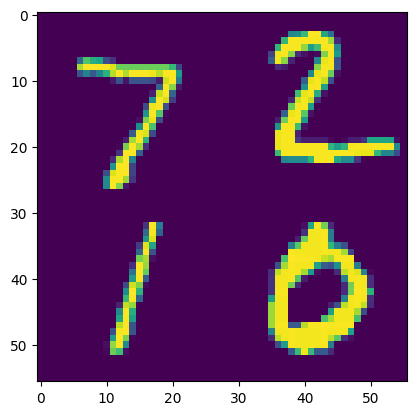

In [324]:
for i in ds_new['test']:
    print(i['label'])
    plt.imshow(i['image'])
    plt.show()
    break


In [325]:
print(len(ds_new['train']), len(ds_new['test']))

30000 5000


In [326]:
ds_new['train'][0]

{'image': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'label': [5, 0, 4, 1]}

In [327]:
ds_new['train'][0]['image'].shape

(56, 56)

In [328]:
from sklearn.model_selection import train_test_split

In [329]:
#prepare the dataloader for the new dataset, broadcast the labels for each patch
def prepare_data(data):
    #create 16 sequences out of each image
    data['image'] = torch.tensor(np.array(data['image']), dtype=torch.float32).view(16, 14, 14)
    #reshape the image to 16 sequences
    data['image'] = data['image'].reshape(16, 14*14)
    #normalize the image
    data['image'] = data['image'] / 255
    #data['label'] keep as numbers so no tokenizer is needed
    #start token is going to be 11 (its not part of the labels)
    #end token is going to be 12
    labels_start = [10] + data['label']
    labels_end = data['label'] + [11]

    return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(labels_start, dtype=torch.long), torch.tensor(labels_end, dtype=torch.long)


class ImageDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return prepare_data(self.data[idx])
    
    def collate_fn(batch):
        images, labels_start, labels_end = zip(*batch)
        # print('images: ', images)
        # print('labels: ', labels)
        images = torch.stack(images)
        labels_start = torch.stack(labels_start)
        labels_end = torch.stack(labels_end)
        return images, labels_start, labels_end

ds_tot = ds_new['train']
ds_tot.extend(ds_new['test'])
#split the dataset into train test
train, test = train_test_split(ds_tot, test_size=0.2, random_state=42)  
# train_dataset = ImageDataset(ds_new['train'])
train_dataset = ImageDataset(train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=ImageDataset.collate_fn)
# test_dataset = ImageDataset(ds_new['test'])
test_dataset = ImageDataset(test)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, collate_fn=ImageDataset.collate_fn)

In [330]:
for im, l1, l2 in test_loader:
    print(im)
    print(l1)
    print(l2)
    break

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([[10,  1,  8,  7,  7],
        [10,  6,  3,  7,  3]])
tensor([[ 1,  8,  7,  7, 11],
        [ 6,  3,  7,  3, 11]])


/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_22416/2127848479.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(labels_start, dtype=torch.long), torch.tensor(labels_end, dtype=torch.long)


## make the decoder

In [331]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        Args:
            d_model (int): Dimensionality of the model (embedding size).
            max_len (int): Maximum length of input sequences.
        """
        super(PositionalEncoding, self).__init__()
        # Create a long enough 'pe' matrix with shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # Apply sin to even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Apply cos to odd indices
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x (Tensor): Input of shape (batch_size, seq_len, d_model)
        Returns:
            Tensor: x plus positional encodings.
        """
        # print('before encoding:', x.shape)
        # print('pe shape:', self.pe[:, :x.size(1)].shape)
        x = x + self.pe[:, :x.size(1)]
        return x

In [332]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        
        # Position-wise feed-forward network.
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, value, key, query, mask=None):
        # Multi-head self-attention sublayer with residual connection.
        attn_output, _ = self.self_attn(value, key, query, mask)
        x = self.layernorm1(attn_output + self.dropout1(attn_output))
        
        # Feed-forward sublayer with residual connection.
        ffn_output = self.ffn(x)
        x = self.layernorm2(x + self.dropout2(ffn_output))
        return x

In [333]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        """
        Args:
            d_model (int): Embedding Model dimension.
            num_heads (int): Number of attention heads.
            dropout (float): Dropout probability.
        """
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head
        self.linear_q = nn.Linear(d_model, d_model)
        self.linear_k = nn.Linear(d_model, d_model)
        self.linear_v = nn.Linear(d_model, d_model)
        
        # Final linear layer after concatenating heads.
        self.linear_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, value, key, query, mask=None):
        batch_size = query.size(0)
        
        # Linear projections and reshape into (batch_size, num_heads, seq_len, d_k)
        Q = self.linear_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.linear_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.linear_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # Compute scaled dot-product attention.
        # scores: (batch_size, num_heads, seq_len, seq_len)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        # print('mask: ', mask)
        # print('scores shape: ', scores.shape)
        if mask is not None:
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        
        # Compute weighted sum of values.
        # context: (batch_size, num_heads, seq_len, d_k)
        context = torch.matmul(attn, V)
        # Concatenate heads and put through final linear layer.
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        output = self.linear_out(context)
        return output, attn

In [334]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        
        self.tranformer_block = EncoderLayer(d_model, num_heads, d_ff, dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, x, value, key, target_mask=None):
        # Multi-head self-attention sublayer with residual connection.
        attn_output, attn_weights = self.self_attn(x, x, x, target_mask)
        query = self.layernorm1(x + self.dropout1(attn_output))
        
        # Feed-forward sublayer with residual connection.
        ffn_output = self.tranformer_block(value, key, query)
        x = self.layernorm2(x + self.dropout2(ffn_output))
        return x, attn_weights


In [335]:
class TransformerEncoder(nn.Module):
    def __init__(self, image_size, d_model, num_layers, num_heads, d_ff, max_seq_len, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Linear(image_size*image_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=max_seq_len)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
    
    def forward(self, src, mask=None):
        """
        Args:
            src (Tensor): Input tensor of token indices with shape (batch_size, seq_len).
            mask (Tensor, optional): Attention mask.
        Returns:
            x (Tensor): Encoder output of shape (batch_size, seq_len, d_model).
            all_attn (list): List of attention weight tensors from each layer.
        """
        x = self.embedding(src)
        x = self.pos_enc(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, x, x, mask)
        return x

In [336]:
class TransformerDecoder(nn.Module):
    def __init__(self, n_vocab, d_model, num_layers, num_heads, d_ff, max_seq_len, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Embedding(n_vocab, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=max_seq_len)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.linear = nn.Linear(d_model, n_vocab)
    
    def forward(self, x, encoder_out, target_mask):
        x = self.embedding(x)
        x = self.pos_enc(x)
        x = self.dropout(x)
        all_attn = []
        #here we combine the encoder output with the decoder output
        #the decoder output is x and the encoder output is encoder_out
        #the decoder output x is the "query" and the encoder output (encoder_out) is the "key" and the "value"
        # print('target_mask TD: ', target_mask)
        # print('target_mask shape: ', target_mask.shape)
        for layer in self.layers:
            x, attn = layer(x, encoder_out, encoder_out, target_mask)
            all_attn.append(attn)

        # pooled = torch.mean(x, dim=1)  # shape: (batch_size, d_model)
        logits = self.linear(x)  # shape: (batch_size, num_classes)
        return logits

In [337]:
d_model = 15
embedding = nn.Embedding(10, d_model)
embedding(torch.tensor([0, 1, 2, 2, 3, 4, 5, 6, 9])).shape

torch.Size([9, 15])

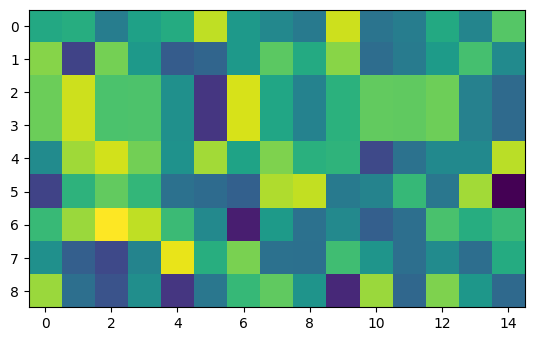

In [338]:
embedding = nn.Embedding(10, d_model)

plt.imshow(embedding(torch.tensor([0, 1, 2, 2, 3, 4, 5, 6, 9])).detach().numpy())
plt.show()

In [339]:
def triangular_mask(target):
    batch_size, seq_len = target.size()
    mask = torch.tril(torch.ones((seq_len, seq_len), device=target.device), diagonal=0)
    mask = mask.unsqueeze(0).expand(batch_size, -1, -1)
    return mask

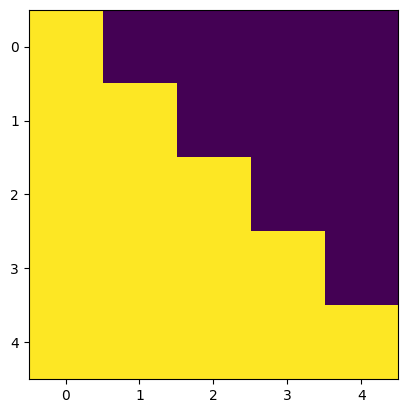

In [340]:
#attention kernel:= num words x num words (or num patches x num patches)
target = torch.tensor([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [6, 7, 8, 9, 10], [6, 7, 8, 9, 10]])
res = triangular_mask(target)
plt.imshow(res[0].detach().numpy())
plt.show()

In [341]:
res.shape

torch.Size([4, 5, 5])

In [342]:
#putting it all together

In [343]:
n_categories = 12 #size of vocabulary (num letters is 10)=n_vocab+start and end token
d_model = 128 #the size of the embedding
num_layers = 4
num_heads = 8
d_ff = 256 # the size of the feed forward connection in the encoder and decoder
max_seq_len = 16 #the size of the sequence in the input (number of patches)
dropout = 0.1
image_size = 14 #the size of the image-patch

#write the entire transformer


class Transformer(nn.Module):
    def __init__(self, image_size, d_model, num_layers, num_heads, d_ff, max_seq_len, n_categories, dropout=0.1):
        super(Transformer, self).__init__()
        self.encoder = TransformerEncoder(image_size, d_model, num_layers, num_heads, d_ff, max_seq_len, dropout)
        self.decoder = TransformerDecoder(n_categories, d_model, num_layers, num_heads, d_ff, max_seq_len, dropout)

    def forward(self, src, target):
        trg_mask = triangular_mask(target)
        enc_src = self.encoder(src)
        out = self.decoder(target, enc_src, trg_mask)

        return out


In [344]:
for i, l1, l2 in test_loader:
    example_X = i
    example_y1 = l1
    example_y2 = l2
    break

/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_22416/2127848479.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(labels_start, dtype=torch.long), torch.tensor(labels_end, dtype=torch.long)


In [345]:
print(example_X.shape, example_y1.shape)

torch.Size([2, 16, 196]) torch.Size([2, 5])


In [346]:
test_dataset[0]

/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_22416/2127848479.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(labels_start, dtype=torch.long), torch.tensor(labels_end, dtype=torch.long)


(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([10,  0,  1,  6,  4]),
 tensor([ 0,  1,  6,  4, 11]))

torch.Size([16, 196]) torch.Size([5])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([10,  5,  9,  4,  9])


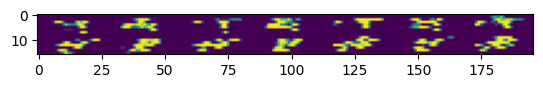

In [347]:
print(example_X[0].shape, example_y1[0].shape)
print(example_X[0], example_y1[0])
plt.imshow(example_X[0].detach().numpy())
plt.show()

In [352]:
model = Transformer(image_size, d_model, num_layers, num_heads, d_ff, max_seq_len, n_categories, dropout)

res = model(example_X, example_y1)

In [353]:
res.shape

torch.Size([2, 5, 12])

In [354]:
#make a training loop
n_epochs = 40
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses = []
valid_losses = []
for epoch in range(n_epochs):
    model.train()
    count=0
    batch_losses = []
    for i, l1, l2 in tqdm(train_loader):
        optimizer.zero_grad()
        logits = model(i, l1)
        loss = loss_fn(logits.view(-1, n_categories), l2.view(-1))
        loss.backward()
        optimizer.step()
        count+=1
        if count%100==0:
            print(f'batch {count}, Loss: {loss.item()}')
        # print(f'batch {count}, Loss: {loss.item()}')
        #accumulate across batches
        batch_losses.append(loss.item())
    train_loss = np.mean(batch_losses)
    train_losses.append(train_loss)
    #get the loss on the test set
    model.eval()
    with torch.no_grad():
        for i, l1, l2 in tqdm(test_loader):
            logits = model(i, l1)
            loss = loss_fn(logits.view(-1, n_categories), l2.view(-1))
        valid_loss = loss.item()
        valid_losses.append(valid_loss)

    print(f"====Epoch {epoch + 1}, Train Loss: {train_loss}, Validation Loss: {valid_loss}====")
    # print(f"====Epoch {epoch + 1}, Train Loss: {train_loss}====")

  0%|          | 0/438 [00:00<?, ?it/s]/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_22416/2127848479.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(labels_start, dtype=torch.long), torch.tensor(labels_end, dtype=torch.long)
 23%|██▎       | 101/438 [00:08<00:25, 13.27it/s]

batch 100, Loss: 2.317152500152588


 46%|████▌     | 201/438 [00:15<00:17, 13.55it/s]

batch 200, Loss: 2.0424721240997314


 69%|██████▊   | 301/438 [00:22<00:09, 14.38it/s]

batch 300, Loss: 2.040706157684326


 92%|█████████▏| 401/438 [00:29<00:02, 13.60it/s]

batch 400, Loss: 1.9994125366210938


100%|██████████| 438/438 [00:32<00:00, 13.61it/s]


====Epoch 1, Train Loss: 1.9644489288330078====


 23%|██▎       | 101/438 [00:07<00:24, 13.79it/s]

batch 100, Loss: 1.8947471380233765


 46%|████▌     | 201/438 [00:14<00:16, 14.18it/s]

batch 200, Loss: 1.8612878322601318


 69%|██████▊   | 301/438 [00:22<00:10, 12.54it/s]

batch 300, Loss: 1.8910318613052368


 92%|█████████▏| 401/438 [00:29<00:02, 13.81it/s]

batch 400, Loss: 1.8631927967071533


100%|██████████| 438/438 [00:32<00:00, 13.61it/s]


====Epoch 2, Train Loss: 1.8589389324188232====


 23%|██▎       | 101/438 [00:07<00:23, 14.13it/s]

batch 100, Loss: 1.8535600900650024


 46%|████▌     | 201/438 [00:14<00:17, 13.87it/s]

batch 200, Loss: 1.8414777517318726


 69%|██████▊   | 301/438 [00:21<00:09, 13.72it/s]

batch 300, Loss: 1.8399368524551392


 92%|█████████▏| 401/438 [00:28<00:02, 13.95it/s]

batch 400, Loss: 1.8557955026626587


100%|██████████| 438/438 [00:31<00:00, 14.08it/s]


====Epoch 3, Train Loss: 1.8434813022613525====


 23%|██▎       | 102/438 [00:07<00:24, 13.98it/s]

batch 100, Loss: 1.8500697612762451


 46%|████▌     | 202/438 [00:14<00:16, 14.06it/s]

batch 200, Loss: 1.8412542343139648


 69%|██████▉   | 302/438 [00:21<00:09, 14.02it/s]

batch 300, Loss: 1.8609421253204346


 92%|█████████▏| 402/438 [00:28<00:02, 14.22it/s]

batch 400, Loss: 1.8647702932357788


100%|██████████| 438/438 [00:31<00:00, 14.08it/s]


====Epoch 4, Train Loss: 1.830450415611267====


 23%|██▎       | 102/438 [00:07<00:23, 14.15it/s]

batch 100, Loss: 1.8438857793807983


 46%|████▌     | 202/438 [00:14<00:16, 14.22it/s]

batch 200, Loss: 1.8597862720489502


 69%|██████▉   | 302/438 [00:21<00:09, 14.03it/s]

batch 300, Loss: 1.8510735034942627


 92%|█████████▏| 402/438 [00:28<00:02, 14.48it/s]

batch 400, Loss: 1.8406846523284912


100%|██████████| 438/438 [00:31<00:00, 13.98it/s]


====Epoch 5, Train Loss: 1.8539342880249023====


 23%|██▎       | 102/438 [00:07<00:23, 14.29it/s]

batch 100, Loss: 1.8567402362823486


 46%|████▌     | 202/438 [00:14<00:16, 14.12it/s]

batch 200, Loss: 1.8429450988769531


 69%|██████▉   | 302/438 [00:21<00:09, 14.18it/s]

batch 300, Loss: 1.8456271886825562


 92%|█████████▏| 402/438 [00:28<00:02, 13.73it/s]

batch 400, Loss: 1.8481833934783936


100%|██████████| 438/438 [00:31<00:00, 14.09it/s]


====Epoch 6, Train Loss: 1.853222131729126====


 23%|██▎       | 102/438 [00:07<00:23, 14.15it/s]

batch 100, Loss: 1.8379793167114258


 46%|████▌     | 202/438 [00:14<00:16, 14.09it/s]

batch 200, Loss: 1.847330093383789


 69%|██████▉   | 302/438 [00:22<00:10, 12.70it/s]

batch 300, Loss: 1.8771545886993408


 92%|█████████▏| 402/438 [00:29<00:02, 12.96it/s]

batch 400, Loss: 1.838775873184204


100%|██████████| 438/438 [00:32<00:00, 13.47it/s]


====Epoch 7, Train Loss: 1.832269310951233====


 23%|██▎       | 102/438 [00:07<00:25, 13.01it/s]

batch 100, Loss: 1.848621129989624


 46%|████▌     | 202/438 [00:14<00:16, 14.10it/s]

batch 200, Loss: 1.8449910879135132


 69%|██████▉   | 302/438 [00:22<00:09, 13.83it/s]

batch 300, Loss: 1.8322824239730835


 92%|█████████▏| 402/438 [00:29<00:02, 13.35it/s]

batch 400, Loss: 1.8425920009613037


100%|██████████| 438/438 [00:32<00:00, 13.57it/s]


====Epoch 8, Train Loss: 1.8458722829818726====


 23%|██▎       | 101/438 [00:07<00:23, 14.18it/s]

batch 100, Loss: 1.8417612314224243


 46%|████▌     | 201/438 [00:15<00:17, 13.28it/s]

batch 200, Loss: 1.884108304977417


 69%|██████▊   | 301/438 [00:22<00:09, 14.29it/s]

batch 300, Loss: 1.8614660501480103


 92%|█████████▏| 401/438 [00:29<00:02, 12.71it/s]

batch 400, Loss: 1.849470853805542


100%|██████████| 438/438 [00:32<00:00, 13.36it/s]


====Epoch 9, Train Loss: 1.836986780166626====


 23%|██▎       | 102/438 [00:07<00:23, 14.28it/s]

batch 100, Loss: 1.8455274105072021


 46%|████▌     | 202/438 [00:14<00:17, 13.78it/s]

batch 200, Loss: 1.8577260971069336


 69%|██████▉   | 302/438 [00:22<00:10, 13.37it/s]

batch 300, Loss: 1.8405393362045288


 92%|█████████▏| 402/438 [00:29<00:02, 14.43it/s]

batch 400, Loss: 1.8419147729873657


100%|██████████| 438/438 [00:32<00:00, 13.59it/s]


====Epoch 10, Train Loss: 1.8322776556015015====


 23%|██▎       | 102/438 [00:07<00:23, 14.07it/s]

batch 100, Loss: 1.8797162771224976


 46%|████▌     | 202/438 [00:14<00:16, 14.19it/s]

batch 200, Loss: 1.8516149520874023


 69%|██████▉   | 302/438 [00:21<00:09, 13.96it/s]

batch 300, Loss: 1.8671705722808838


 91%|█████████▏| 400/438 [00:28<00:02, 13.65it/s]

batch 400, Loss: 1.841003656387329


100%|██████████| 438/438 [00:31<00:00, 13.87it/s]


====Epoch 11, Train Loss: 1.8425089120864868====


 23%|██▎       | 102/438 [00:07<00:24, 13.90it/s]

batch 100, Loss: 1.8396971225738525


 46%|████▌     | 202/438 [00:14<00:17, 13.72it/s]

batch 200, Loss: 1.8373901844024658


 69%|██████▉   | 302/438 [00:22<00:10, 13.08it/s]

batch 300, Loss: 1.8297313451766968


 92%|█████████▏| 402/438 [00:29<00:02, 12.60it/s]

batch 400, Loss: 1.8456764221191406


100%|██████████| 438/438 [00:32<00:00, 13.36it/s]


====Epoch 12, Train Loss: 1.8458513021469116====


 23%|██▎       | 102/438 [00:07<00:24, 13.64it/s]

batch 100, Loss: 1.850171685218811


 46%|████▌     | 202/438 [00:14<00:17, 13.70it/s]

batch 200, Loss: 1.83829665184021


 69%|██████▉   | 302/438 [00:22<00:10, 13.22it/s]

batch 300, Loss: 1.8495655059814453


 92%|█████████▏| 402/438 [00:29<00:02, 14.32it/s]

batch 400, Loss: 1.844740867614746


100%|██████████| 438/438 [00:32<00:00, 13.58it/s]


====Epoch 13, Train Loss: 1.8380069732666016====


 23%|██▎       | 102/438 [00:07<00:26, 12.56it/s]

batch 100, Loss: 1.8497352600097656


 46%|████▌     | 202/438 [00:15<00:18, 12.83it/s]

batch 200, Loss: 1.8473951816558838


 69%|██████▉   | 302/438 [00:23<00:10, 13.17it/s]

batch 300, Loss: 1.8429210186004639


 92%|█████████▏| 402/438 [00:30<00:02, 13.62it/s]

batch 400, Loss: 1.846509337425232


100%|██████████| 438/438 [00:33<00:00, 13.20it/s]


====Epoch 14, Train Loss: 1.8459259271621704====


 22%|██▏       | 98/438 [00:07<00:25, 13.29it/s]


KeyboardInterrupt: 

## Add checkpoint and early stopping

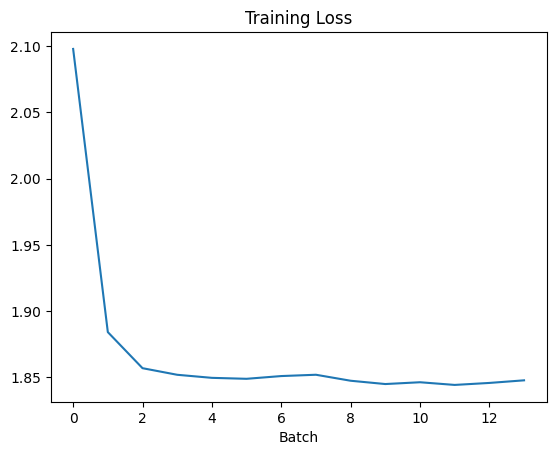

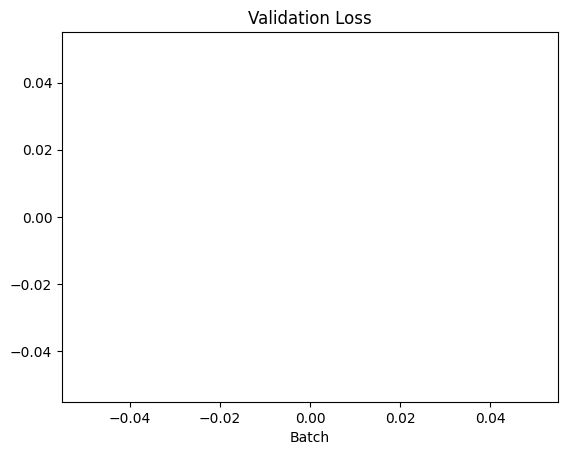

In [355]:
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Batch')
plt.show()
plt.plot(valid_losses)
plt.title('Validation Loss')
plt.xlabel('Batch')
plt.show()

In [189]:
#evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    l_all = []
    pred_all = []
    with torch.no_grad():
        for i, l in test_loader:
            outputs = model(i, l)
            _, predicted = torch.max(outputs.data, 2)
            # print('predicted:', predicted)
            # print('ref: ', l)
            total += l.size(0)*l.size(1)
            correct += (predicted == l).sum().item()
            l_all.extend(l)
            pred_all.extend(predicted)
            
    return correct / total, l_all, pred_all

how_good, y_ref, y_pred = evaluate_model(model, test_loader)

/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_22416/2988214831.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(data['label'], dtype=torch.long)


In [190]:
print(how_good)

1.0


In [191]:
print(y_ref[0], y_pred[0])

tensor([4, 8, 7, 8]) tensor([4, 8, 7, 8])


https://www.youtube.com/watch?v=eMlx5fFNoYc 